In [ ]:
%load_ext autoreload
import os

import numpy as np
from pprint import pprint

%autoreload 2
import zcu_tools.analysis as zf  # noqa: E402
import zcu_tools.schedule.v2 as zs  # noqa: E402
from zcu_tools.analysis.predict import predict01

# ruff: noqa: I001
from zcu_tools import (  # noqa: E402
    DefaultCfg,
    create_datafolder,
    make_cfg,
    make_sweep,
    save_data,
    make_comment,
)

In [2]:
import zcu_tools.config as zc

# zc.config.DATA_DRY_RUN = True  # don't save data
# zc.config.YOKO_DRY_RUN = True  # don't run yoko

# Connect to zcu216

In [29]:
from zcu_tools.remote import make_proxy
from zcu_tools.program.base import MyProgram  # noqa: E402
from zcu_tools.tools import get_ip_address

zc.config.LOCAL_IP = get_ip_address("Tailscale")
zc.config.LOCAL_PORT = 8887

soc, soccfg, rm_prog = make_proxy("zcu216-1", 8887)
MyProgram.init_proxy(rm_prog, test=True)
print(soccfg)

Sending callback to server...   Callback test  passed !
QICK running on ZCU216, software version 0.2.325

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 8192 samples (0.855 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_sg_int4_v2 - envelope memory 16384 samp

In [ ]:
# from myqick import QickSoc  # noqa: E402
# from zcu_tools.tools import get_bitfile

# soc = QickSoc(bitfile=get_bitfile("v2"))
# soccfg = soc
# print(soc)

# Create data folder

In [493]:
chip_name = "Q12_2D/Q4"

data_host = None

database_path = create_datafolder(os.path.join(os.getcwd(), ".."), prefix=chip_name)

# Predefine parameters

In [55]:
timeFly = 0.3
res_ch = 0
qub_ch = 2

DefaultCfg.set_adc(ro_chs=[0])
# DefaultCfg.set_dev(flux_dev="none", flux=0.0)

In [6]:
# DefaultCfg.load("default_cfg.yaml")

# Initialize the flux

In [7]:
from zcu_tools.device import YokoDevControl  # noqa: E402

YokoDevControl.connect_server(
    {
        # "host_ip": data_host,
        "host_ip": "127.0.0.1",
        "dComCfg": {"address": "0x0B21::0x0039::91WB18861", "interface": "USB"},
        "outputCfg": {"Current - Sweep rate": 10e-6},
    },
    reinit=True,
)
DefaultCfg.set_dev(flux_dev="yoko")

Activate globalFlux successfully.


In [ ]:
cur_A = YokoDevControl.get_current()
cur_A

0.0038

In [ ]:
cur_A = 2.5e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)

  0%|          | 0/1.0 [00:00<?, ?mA/s]

# Probe pulse

In [482]:
DefaultCfg.set_pulse(
    probe_rf={
        # "style": "const",
        # "style": "cosine",
        # "style": "gauss",
        # "sigma": 9.5/4,  # us
        "style": "flat_top",
        # "raise_pulse": {"style": "gauss", "length": 5.0, "sigma": 0.2},
        "raise_pulse": {"style": "cosine", "length": 0.1},
        "length": 2.1,  # us
        # "trig_offset": 0.0,  # us
        "trig_offset": timeFly,
        "ro_length": 2.0,  # us
    },
)
pprint(DefaultCfg.dac_cfgs["pulses"]["probe_rf"])

{'length': 2.1,
 'raise_pulse': {'length': 0.1, 'style': 'cosine'},
 'ro_length': 2.0,
 'style': 'flat_top',
 'trig_offset': 0.498046875}


# Lookback

In [477]:
exp_cfg = {
    "dac": {
        "res_pulse": {
            **DefaultCfg.get_pulse("probe_rf"),
            # **DefaultCfg.get_pulse("readout_dpm"),
            "ch": 0,
            "nqz": 2,
            "gain": 1.0,
            # "gain": 30000,
            # "freq": 7530,
            "freq": r_f,
        },
    },
    "adc": {
        "ro_length": 3.0,  # us
        # "trig_offset": 0.0,  # us
        "trig_offset": 0.0,  # us
        "relax_delay": 0.1,  # us
    },
}

In [478]:
cfg = make_cfg(exp_cfg, rounds=10000)

Ts, signals = zs.measure_lookback(soc, soccfg, cfg, progress=True)

Soft_avgs:   0%|          | 0/10000 [00:00<?, ?it/s]

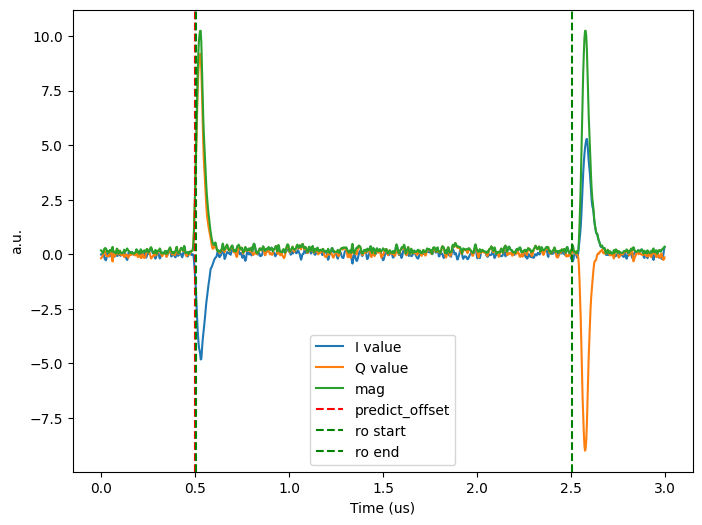

0.498046875

In [479]:
predict_offset = zf.lookback_show(
    Ts,
    signals,
    ratio=0.15,
    plot_fit=True,
    smooth=1.0,
    pulse_cfg=cfg["dac"]["res_pulse"],
)
predict_offset

In [480]:
timeFly = float(predict_offset)
timeFly

0.498046875

In [481]:
filename = "lookback"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Time", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"adc_trig_offset = {timeFly}us"),
    tag="Lookback",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0425\lookback_2.hdf5


# Resonator Frequency

In [1486]:
res_name = "R4"

In [1498]:
exp_cfg = {
    "dac": {
        # "res_pulse": "readout_rf",
        "res_pulse": {
            **DefaultCfg.get_pulse("probe_rf"),
            "ch": 0,
            "nqz": 2,
            "gain": 0.1,
            # "gain": 3000,
        },
        # "reset": "pulse",
        # "reset_pulse": "reset_red"
    },
    "adc": {
        "relax_delay": 0.1,  # us
    },
}

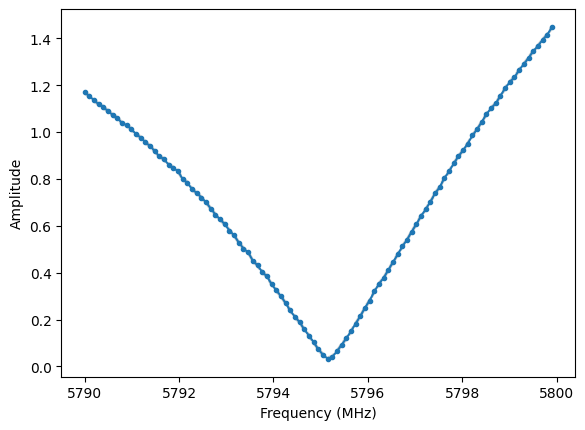

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

In [1499]:
exp_cfg["sweep"] = make_sweep(5790, 5800, 101)
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

fpts, signals = zs.measure_res_freq(soc, soccfg, cfg)

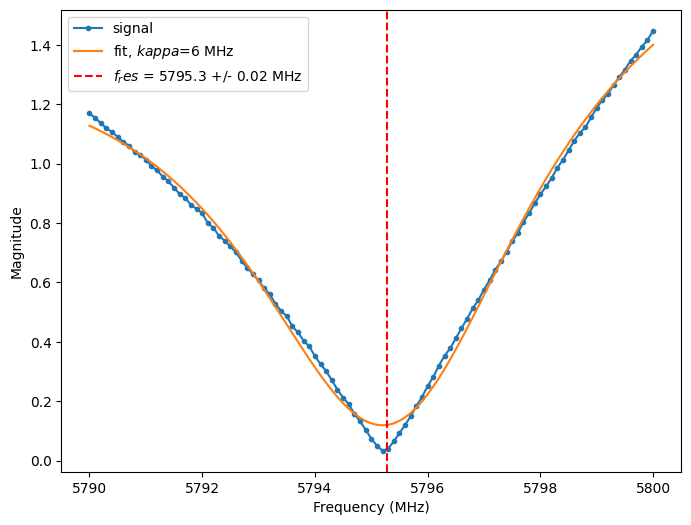

5795.279954910392

In [1500]:
r_f = zf.freq_analyze(fpts, signals, asym=True)
r_f

In [1501]:
filename = f"{res_name}_freq@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"resonator frequency = {r_f}MHz"),
    # comment=make_comment(cfg),
    tag="OneTone/single",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\R4_freq@3.370mA_2.hdf5


In [1502]:
# r_f =  6026.1
r_f

5795.279954910392

# Onetone Dependences

## Power Dependence

In [1506]:
exp_cfg = {
    "dac": {
        "res_pulse": {
            **DefaultCfg.get_pulse("probe_rf"),
            "ch": 0,
            "nqz": 1,
        },
        # "reset": "pulse",
        # "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 0.1,  # us
    },
}

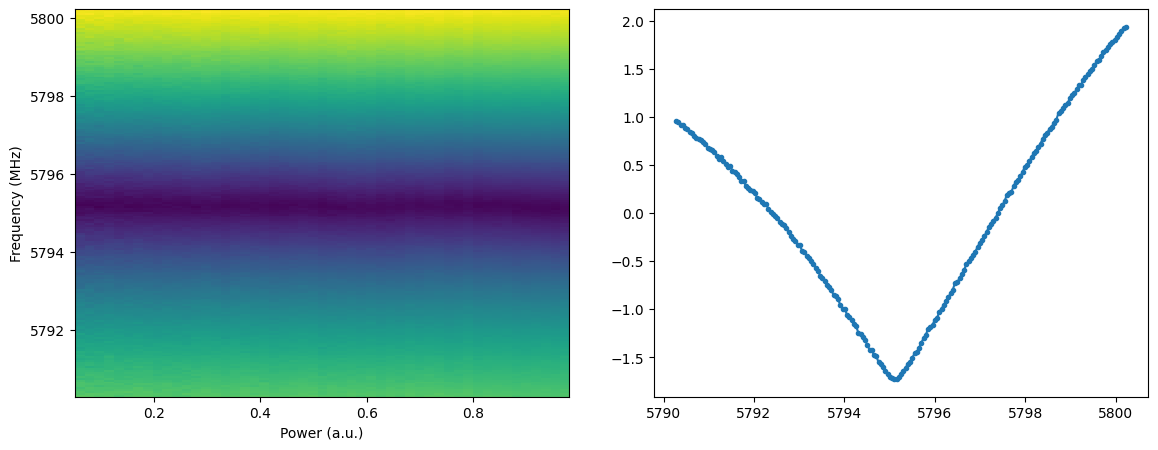

Power (a.u.):   0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [1507]:
exp_cfg["sweep"] = {
    "gain": make_sweep(0.05, 1.0, 51),
    # "gain": make_sweep(10, 30000, 30, force_int=True),
    # "freq": make_sweep(7522.5, 7535, 100),
    "freq": make_sweep(r_f-5, r_f+5, 201),
}
cfg = make_cfg(exp_cfg, reps=1000, rounds=10)

pdrs, fpts, signals2D = zs.measure_res_pdr_dep(
    soc, soccfg, cfg, dynamic_avg=True, gain_ref=0.1
)

In [1508]:
filename = f"{res_name}_pdr@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    y_info={"name": "Power", "unit": "a.u.", "values": pdrs},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals2D},
    comment=make_comment(cfg),
    tag="OneTone/pdr",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\R4_pdr@3.370mA_2.hdf5


## Flux dependence

In [ ]:
cur_A = -3.2e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)

In [ ]:
exp_cfg = {
    "dac": {
        "res_pulse": {
            **DefaultCfg.get_pulse("probe_rf"),
            "nqz": 2,
            # "gain": 1.0,
            "gain": 30000,
        },
    },
    "adc": {
        "relax_delay": 0.0,  # us
    },
}

In [ ]:
exp_cfg["sweep"] = {
    "flux": make_sweep(-3.2e-3, -4.3e-3, 11),
    "freq": make_sweep(5020, 6030, 11),
}
cfg = make_cfg(exp_cfg, reps=1, rounds=1)

flxs, fpts, signals2D = zs.measure_res_flux_dep(soc, soccfg, cfg)

In [ ]:
filename = f"{res_name}_flux"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    y_info={"name": "Flux", "unit": "a.u.", "values": flxs},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals2D},
    comment=make_comment(cfg),
    tag="OneTone/flux",
    server_ip=data_host,
)

In [ ]:
cur_A = -3.8e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)

# Set readout pulse

In [1509]:
# r_f = 7000.0
DefaultCfg.set_pulse(
    readout_rf={
        **DefaultCfg.get_pulse("probe_rf"),
        "ch": 0,
        "nqz": 2,
        "freq": r_f,  # MHz
        "gain": 0.3,
        # "gain": 30000,
        "desc": "lower power readout with exact resonator frequency",
    },
)
pprint(DefaultCfg.get_pulse("readout_rf"))

{'ch': 0,
 'desc': 'lower power readout with exact resonator frequency',
 'freq': 5795.279954910392,
 'gain': 0.3,
 'length': 2.1,
 'nqz': 2,
 'raise_pulse': {'length': 0.1, 'style': 'cosine'},
 'ro_length': 2.0,
 'style': 'flat_top',
 'trig_offset': 0.498046875}


# TwoTone

In [1510]:
qub_name = "Q4"

In [1511]:
DefaultCfg.set_pulse(
    probe_qf={
        "style": "flat_top",
        # "raise_pulse": {"style": "gauss", "length": 0.02, "sigma": 0.003},
        "raise_pulse": {"style": "cosine", "length": 0.02},
    },
)
pprint(DefaultCfg.get_pulse("probe_qf"))

{'raise_pulse': {'length': 0.02, 'style': 'cosine'}, 'style': 'flat_top'}


# Twotone Frequency

In [1512]:
cur_A = 3.37e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)
cur_A

0.00337

In [1513]:
q_f = 1e3*predict01(f"../result/{chip_name}/params.json", 1e3*cur_A, mA_c=4.46)
q_f

2038.599626942597

In [1515]:
exp_cfg = {
    "dac": {
        # "res_pulse": "readout_rf",
        "res_pulse": "readout_dpm",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "ch": qub_ch,
            "nqz":1,
            "gain": 0.3,
            # "gain": 30000,
            "length": 10,  # us
        },
        # "qub_pulse": "reset_red",
        # "qub_pulse": "pi_len",
        # "reset_pulse": "reset_red",
        # "reset": "pulse",
        # "reset_pulse": {
        #     **DefaultCfg.get_pulse('probe_qf'),
        #     "ch": qub_ch,
        #     "nqz": 1,
        #     "freq": q_f,
        #     "gain": 0.25,
        #     "length": 10,  # us
        # },
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

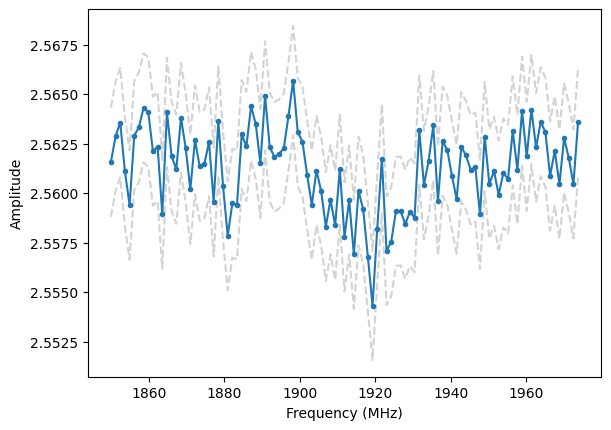

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

In [1516]:
# exp_cfg["sweep"] = make_sweep(r_f-q_f-100, r_f-q_f+100, 101)
# exp_cfg["sweep"] = make_sweep(q_f-200, q_f, 101)
exp_cfg["sweep"] = make_sweep(1850, 1975, 101)
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

er_f = 6020.5
fpts, signals = zs.measure_qub_freq(
    soc, soccfg, cfg, reset_rf=None, remove_bg=True
)

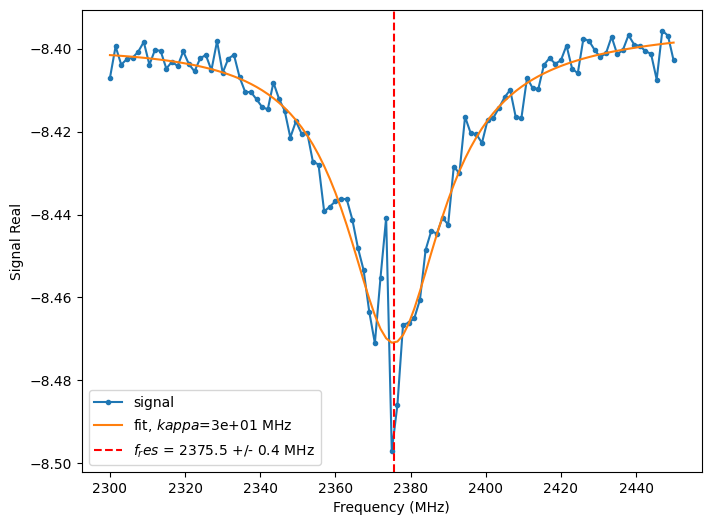

2375.479449288809

In [1435]:
f = zf.freq_analyze(fpts, signals, max_contrast=True)
f

In [1436]:
q_f = f
# reset_f = f
# reset_f = r_f - q_f

In [1437]:
filename = f"{qub_name}_freq@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"frequency = {f}MHz"),
    tag="TwoTone/single",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_freq@3.120mA_3.hdf5


## reset pulse

In [1427]:
exp_cfg = {
    "dac": {
        # "res_pulse": "readout_rf",
        "res_pulse": "readout_dpm",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "ch": qub_ch,
            "nqz":1,
            "freq": reset_f,
            "gain": 0.5,
        },
        # "qub_pulse": "reset_red",
        # "qub_pulse": "pi_len",
        "reset": "pulse",
        "reset_pulse": {
            **DefaultCfg.get_pulse('probe_qf'),
            "ch": qub_ch,
            "nqz": 1,
            "freq": q_f,
            "gain": 0.25,
            "length": 10,  # us
        },
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

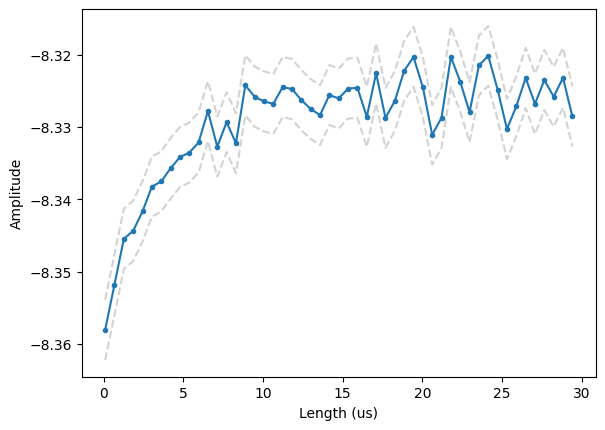

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

Client-side error, raise it on remote side...
Received KeyboardInterrupt, early stopping the program


In [1428]:
exp_cfg["sweep"] = make_sweep(0.1, 30.0, 51)
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

Ts, signals = zs.measure_lenrabi(soc, soccfg, cfg, align_type="post_delay")

In [1429]:
filename = f"{qub_name}_reset_time@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Length", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg),
    tag="TwoTone/reset/time",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_reset_time@3.120mA_1.hdf5


In [1430]:
DefaultCfg.set_pulse(
    reset_red={
        **exp_cfg["dac"]["qub_pulse"],
        "length": 15.0,  # us
        "desc": "Reset pulse by red sideband",
    },
)
DefaultCfg.get_pulse("reset_red")

{'style': 'flat_top',
 'raise_pulse': {'style': 'cosine', 'length': 0.02},
 'ch': 2,
 'nqz': 1,
 'freq': 3424.3829560362465,
 'gain': 0.5,
 'length': 15.0,
 'desc': 'Reset pulse by red sideband'}

# Twotone Dependences

## Power dependence

In [ ]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_rf",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "nqz": 2,
            "length": 5,  # us
        },
    },
    "adc": {
        "relax_delay": 0.0,  # us
    },
}

In [ ]:
exp_cfg["sweep"] = {
    # "gain": make_sweep(0.05, 1.0, 30),
    "gain": make_sweep(10, 30000, 30, force_int=True),
    "freq": make_sweep(1700, 2000, 30),
}
cfg = make_cfg(exp_cfg, reps=50, rounds=50)

fpts, pdrs, signals2D = zs.measure_qub_pdr_dep(soc, soccfg, cfg)

In [ ]:
filename = f"{qub_name}_pdr@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    y_info={"name": "Power", "unit": "a.u.", "values": pdrs},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals2D},
    comment=make_comment(cfg),
    tag="TwoTone/pdr",
    server_ip=data_host,
)

## Flux Dependence

In [ ]:
cur_A = -4.65e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)

In [ ]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_rf",
        # "res_pulse": "readout_dpm",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "nqz": 2,
            "gain": 30000,
            "length": 5,  # us
        },
        # "reset": "pulse",
        # "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 0.0,  # us
    },
}

In [ ]:
exp_cfg["sweep"] = {
    "flux": make_sweep(-4.65e-3, -4.46e-3, 11),
    "freq": make_sweep(5000, 8000, 101),
}
cfg = make_cfg(exp_cfg, reps=1000, rounds=1000)

fpts, flxs, signals2D = zs.measure_qub_flux_dep(
    soc, soccfg, cfg, reset_rf=None, earlystop_snr=13
)

In [ ]:
filename = f"{qub_name}_flux_dep"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    y_info={"name": "Flux", "unit": "a.u.", "values": flxs},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals2D},
    comment=make_comment(cfg),
    tag="TwoTone/flux",
    server_ip=data_host,
)

In [ ]:
cur_A = 6.0292e-3
YokoDevControl.set_current(cur_A)
DefaultCfg.set_dev(flux=cur_A)

# Rabi

## Length Rabi

In [1451]:
exp_cfg = {
    "dac": {
        # "res_pulse": "readout_rf",
        "res_pulse": "readout_dpm",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "ch": qub_ch,
            "nqz": 1,
            "freq": q_f,
            "gain": 0.2,
            # "gain": 30000,
        },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

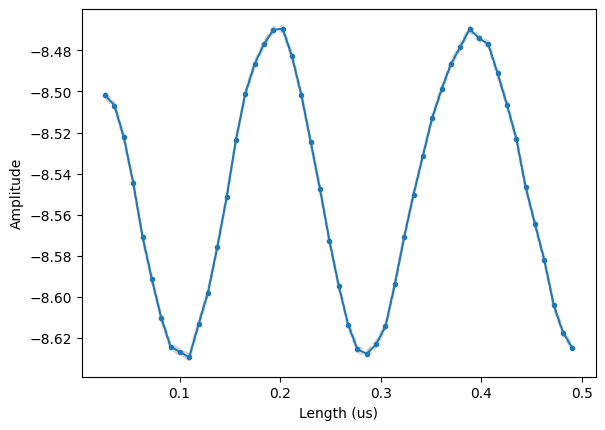

Soft_avgs:   0%|          | 0/1000 [00:00<?, ?it/s]

Client-side error, raise it on remote side...
Received KeyboardInterrupt, early stopping the program


In [1452]:
exp_cfg["sweep"] = make_sweep(0.026, 0.5, 51)
cfg = make_cfg(exp_cfg, reps=1000, rounds=1000)

Ts, signals = zs.measure_lenrabi(soc, soccfg, cfg, align_type="pre_delay")

(0.09092742742402322, 0.04732255612083914)

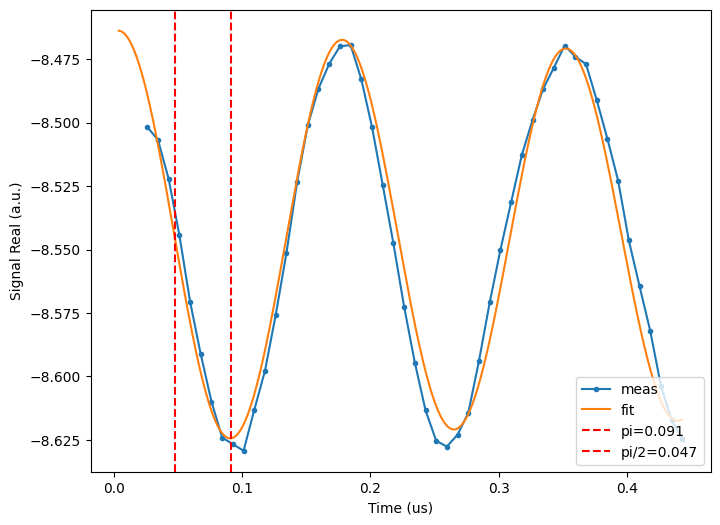

In [1453]:
%matplotlib inline
pi_len, pi2_len = zf.rabi_analyze(
    Ts, signals, decay=True, max_contrast=True, xlabel="Time (us)"
)
pi_len, pi2_len

In [1454]:
filename = f"{qub_name}_len_rabi@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Pulse Length", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"pi len = {pi_len}us\npi/2 len = {pi2_len}us"),
    tag="TimeDomain/len_rabi",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_len_rabi@3.120mA_2.hdf5


In [1455]:
# pi_len = 1.0
# pi2_len = 0.5

In [1456]:
DefaultCfg.set_pulse(
    pi_len={
        **cfg["dac"]["qub_pulse"],
        "length": pi_len,
        "desc": "len pi pulse",
    },
    pi2_len={
        **cfg["dac"]["qub_pulse"],
        "length": pi2_len,
        "desc": "len pi/2 pulse",
    },
)
pprint(DefaultCfg.get_pulse("pi_len"))

{'ch': 2,
 'desc': 'len pi pulse',
 'freq': 2372.9048030934555,
 'gain': 0.2,
 'length': 0.09092742742402322,
 'nqz': 1,
 'phase': 0.0,
 'raise_pulse': {'length': 0.02, 'style': 'cosine'},
 'style': 'flat_top'}


## Amplitude Rabi

In [1457]:
# qub_len = 0.2
qub_len = pi_len * 2.0
exp_cfg = {
    "dac": {
        # "res_pulse": "readout_rf",
        "res_pulse": "readout_dpm",
        "qub_pulse": {
            **DefaultCfg.get_pulse("probe_qf"),
            "ch": qub_ch,
            "nqz": 1,
            "freq": q_f,
            "length": qub_len,
        },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

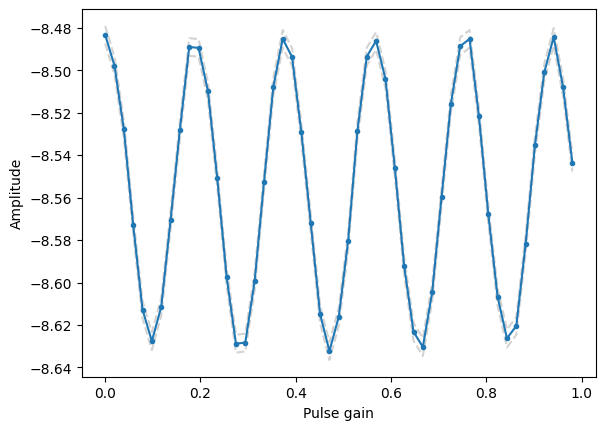

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

In [1458]:
exp_cfg["sweep"] = make_sweep(0, 1.0, 51)
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

pdrs, signals = zs.measure_amprabi(soc, soccfg, cfg)

(0.09905088945510702, 0.05138988053191478)

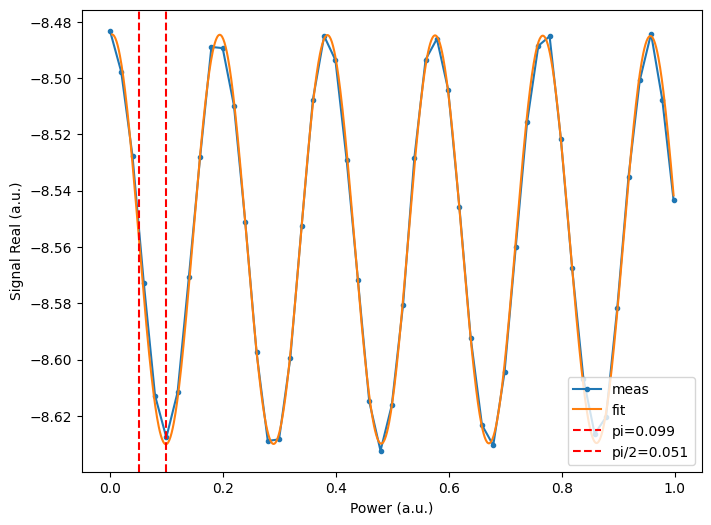

In [1459]:
pi_gain, pi2_gain = zf.rabi_analyze(
    pdrs, signals, decay=True, max_contrast=True, xlabel="Power (a.u.)"
)
pi_gain = int(pi_gain + 0.5) if pi_gain > 1.0 else pi_gain
pi2_gain = int(pi2_gain + 0.5) if pi2_gain > 1.0 else pi2_gain
pi_gain, pi2_gain

In [1460]:
filename = f"{qub_name}_amp_rabi@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Amplitude", "unit": "a.u.", "values": pdrs},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"pi gain = {pi_gain}\npi/2 gain = {pi2_gain}"),
    tag="TimeDomain/amp_rabi",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_amp_rabi@3.120mA_1.hdf5


In [1461]:
# pi_gain = 30000
# pi2_gain = 15000

In [1462]:
DefaultCfg.set_pulse(
    pi_amp={
        **cfg["dac"]["qub_pulse"],
        "gain": pi_gain,
        "desc": "amp pi pulse",
    },
    pi2_amp={
        **cfg["dac"]["qub_pulse"],
        "gain": pi2_gain,
        "desc": "amp pi/2 pulse",
    },
)
pprint(DefaultCfg.get_pulse("pi_amp"))

{'ch': 2,
 'desc': 'amp pi pulse',
 'freq': 2372.9048030934555,
 'gain': 0.09905088945510702,
 'length': 0.18185485484804645,
 'nqz': 1,
 'phase': 0.0,
 'raise_pulse': {'length': 0.02, 'style': 'cosine'},
 'style': 'flat_top'}


# Dispersive shift

## Power dependence

In [1463]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_dpm",
        # "qub_pulse": "pi_len",
        "qub_pulse": "pi_amp",
        # "qub_pulse": "reset_red",
        # "qub_pulse": {
        #     **DefaultCfg.get_pulse('probe_qf'),
        #     "ch": qub_ch,
        #     "nqz": 1,
        #     "freq": q_f,
        #     "gain": 1.0,
        #     "length": 5,  # us
        # },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

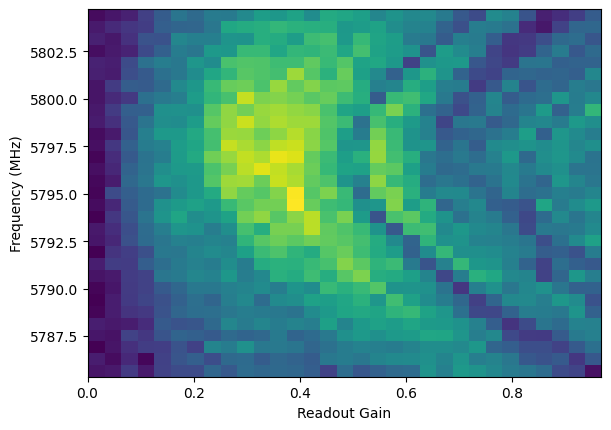

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

Client-side error, raise it on remote side...
Received KeyboardInterrupt, early stopping the program


In [1464]:
exp_cfg["sweep"] = {
    # "gain": make_sweep(500, 30000, 5, force_int=True),
    "gain": make_sweep(0.0, 1.0, 31),
    "freq": make_sweep(r_f-10, r_f+10, 31),
}
# cfg = make_cfg(exp_cfg, reps=5000, rounds=1)
cfg = make_cfg(exp_cfg, reps=100, rounds=100)

pdrs, fpts, snr2D = zs.qubit.measure_ge_pdr_dep2D(soc, soccfg, cfg)
# best_params = zs.qubit.ge_different.measure_ge_pdr_dep_auto(
#     soc, soccfg, cfg, method="Nelder-Mead"
# )

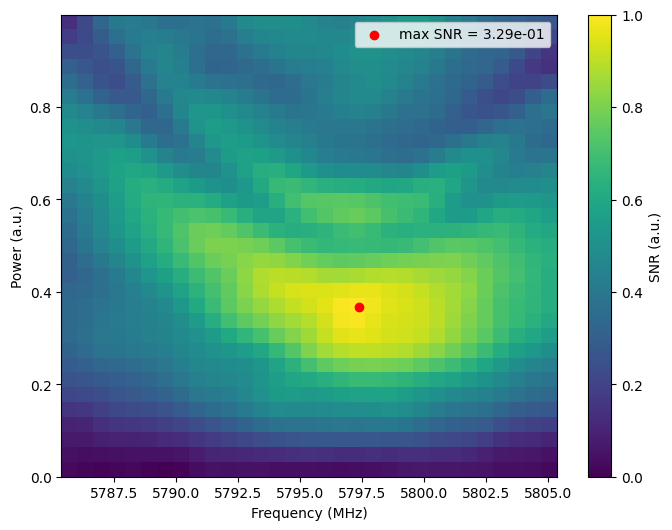

(5797.3665584564205, 0.36659952389672223)

In [1465]:
fpt_max, pdr_max = zf.dispersive2D_analyze(
    fpts, pdrs, snr2D, xlabel="Frequency (MHz)", ylabel="Power (a.u.)"
)
fpt_max, pdr_max

In [1466]:
filename = f"{qub_name}_ge_pdr_fpt@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Frequency", "unit": "Hz", "values": fpts * 1e6},
    y_info={"name": "Power", "unit": "a.u.", "values": pdrs},
    z_info={"name": "SNR", "unit": "a.u.", "values": snr2D},
    comment=make_comment(cfg),
    tag="TwoTone/dispersive/pdr_fpt",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_ge_pdr_fpt@3.120mA_1.hdf5


## Readout dependence

In [1468]:
exp_cfg = {
    "dac": {
        "res_pulse": {
            **DefaultCfg.get_pulse("readout_rf"),
            "freq": fpt_max,
            "gain": pdr_max,
        },
        # "qub_pulse": "pi_len",
        "qub_pulse": "pi_amp",
        # "qub_pulse": "reset_red",
        # "qub_pulse": {
        #     **DefaultCfg.get_pulse('probe_qf'),
        #     "freq": q_f,
        #     "gain": 30000,
        #     "length": 5,  # us
        # },
        "reset": "pulse",
        "reset_pulse": "reset_red"
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

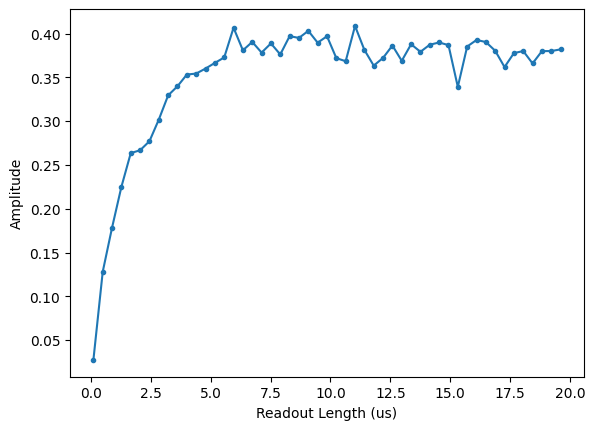

Readout Length (us):   0%|          | 0/51 [00:00<?, ?it/s]

In [1469]:
exp_cfg["sweep"] = make_sweep(0.1, 20.0, 51)
cfg = make_cfg(exp_cfg, reps=100, rounds=100)

ro_lens, snrs = zs.qubit.measure_ge_ro_dep(soc, soccfg, cfg)

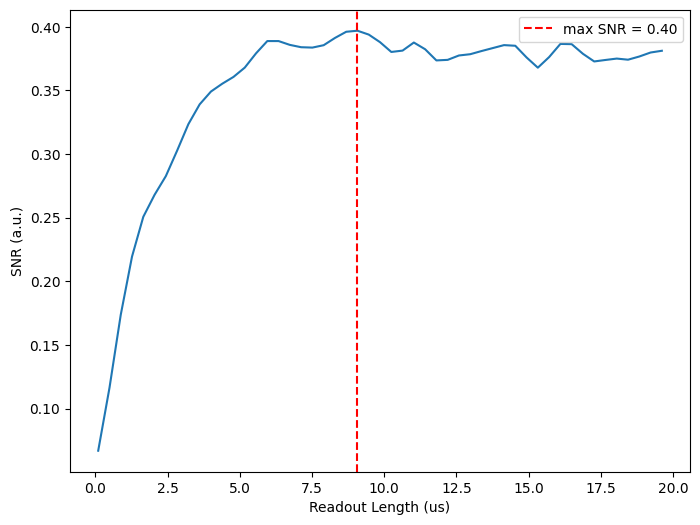

9.074509803921567

In [1470]:
ro_max = zf.dispersive1D_analyze(ro_lens, snrs, xlabel="Readout Length (us)")
ro_max

In [1471]:
filename = f"{qub_name}_ge_ro@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Readout length", "unit": "s", "values": ro_lens * 1e-6},
    z_info={"name": "SNR", "unit": "a.u.", "values": snrs},
    comment=make_comment(cfg),
    tag="TwoTone/dispersive/ro_len",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_ge_ro@3.120mA_1.hdf5


In [1472]:
DefaultCfg.set_pulse(
    readout_dpm={
        **DefaultCfg.get_pulse("readout_rf"),
        "freq": fpt_max,
        "gain": pdr_max,
        "length": ro_max + timeFly + 1.0,
        "ro_length": ro_max,
        "desc": "Readout with largest dispersive shift",
    },
)
pprint(DefaultCfg.get_pulse("readout_dpm"))

{'ch': 0,
 'desc': 'Readout with largest dispersive shift',
 'freq': 5797.3665584564205,
 'gain': 0.36659952389672223,
 'length': 10.572556678921567,
 'nqz': 2,
 'raise_pulse': {'length': 0.1, 'style': 'cosine'},
 'ro_length': 9.074509803921567,
 'style': 'flat_top',
 'trig_offset': 0.498046875}


# T2Ramsey

In [1446]:
orig_qf = q_f
exp_cfg = {
    "dac": {
        "res_pulse": "readout_dpm",
        "qub_pulse": "pi2_len",
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

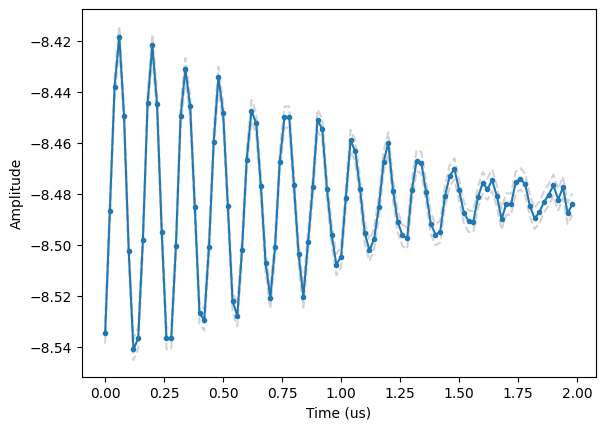

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

In [1447]:
exp_cfg["sweep"] = make_sweep(0, 2.0, 100)  # us
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

activate_detune = 5.0
Ts, signals = zs.measure_t2ramsey(soc, soccfg, cfg, detune=activate_detune)

(7.574646195353781, 0.9417223533903493)

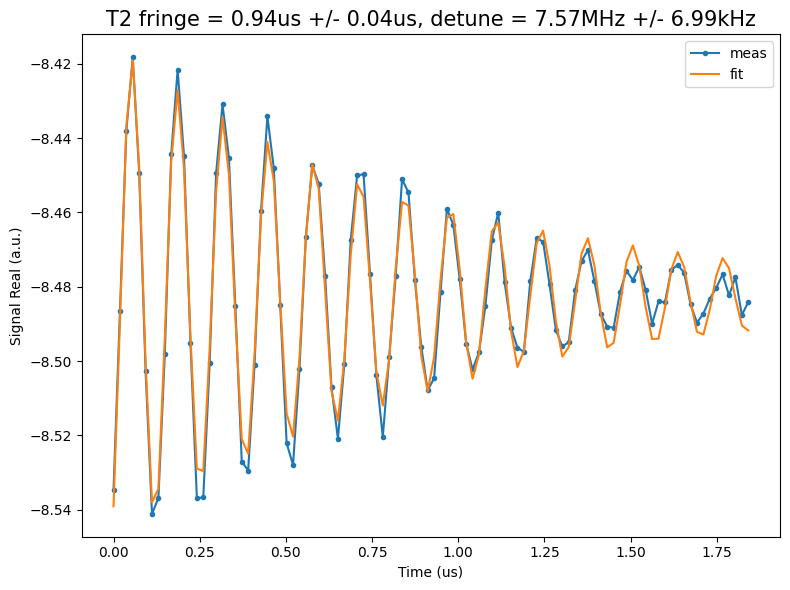

In [1448]:
t2f, detune, _, _ = zf.T2fringe_analyze(Ts, signals, max_contrast=True)  # type: ignore
# t2d, _ = zf.T2decay_analyze(Ts, signals, max_contrast=True)
detune, t2f

In [1449]:
filename = f"{qub_name}_t2ramsey@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Time", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"detune = {detune}MHz\nt2f = {t2f}us\nt2d = {t2d}us"),
    tag="TimeDomain/t2ramsey",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_t2ramsey@3.120mA_1.hdf5


In [1450]:
q_f = orig_qf + activate_detune - detune
q_f

2372.9048030934555

# T1

In [1473]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_dpm",
        "qub_pulse": "pi_amp",
        # "qub_pulse": "pi_len",
        # "qub_pulse": "reset_red",
        # "qub_pulse": {
        #     **DefaultCfg.get_pulse('probe_qf'),
        #     "freq": q_f,
        #     "gain": 30000,
        #     "length": 20,  # us
        # },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

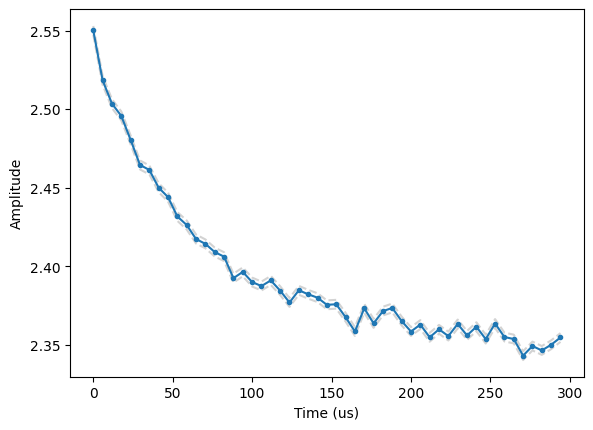

Soft_avgs:   0%|          | 0/100 [00:00<?, ?it/s]

Client-side error, raise it on remote side...
Received KeyboardInterrupt, early stopping the program


In [1474]:
exp_cfg["sweep"] = make_sweep(0, 300, 51)
cfg = make_cfg(exp_cfg, reps=1000, rounds=100)

Ts, signals = zs.measure_t1(soc, soccfg, cfg)

66.04963690009208

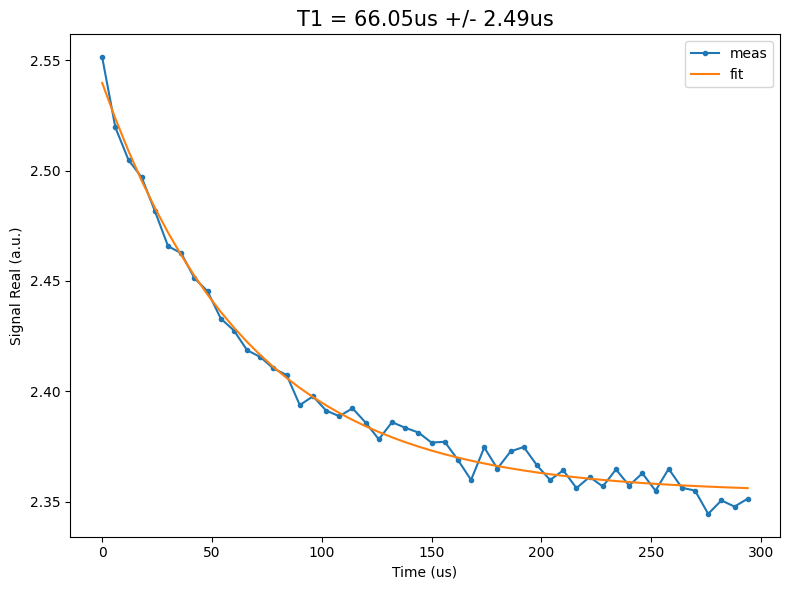

In [1475]:
start = 0
stop = -1

t1, _ = zf.T1_analyze(
    Ts[start:stop], signals[start:stop], max_contrast=True, dual_exp=False
)
t1

In [1476]:
filename = f"{qub_name}_t1@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Time", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"t1 = {t1}us"),
    tag="TimeDomain/t1",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_t1@3.120mA_1.hdf5


# T2Echo

In [ ]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_rf",
        "pi_pulse": "pi_amp",
        "pi2_pulse": "pi2_amp",
        # "reset": "pulse",
        # "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 0.0,  # us
    },
}

In [ ]:
exp_cfg["sweep"] = make_sweep(0, 20, 100)
cfg = make_cfg(exp_cfg, reps=100, rounds=100)

Ts, signals = zs.measure_t2echo(soc, soccfg, cfg)

In [ ]:
t2e, _ = zf.T2decay_analyze(Ts, signals)
t2e

In [ ]:
filename = f"{qub_name}_t2echo@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "Time", "unit": "s", "values": Ts * 1e-6},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    comment=make_comment(cfg, f"t2echo = {t2e}us"),
    tag="TimeDomain/t2echo",
    server_ip=data_host,
)

# Single shot

## Ground state & Excited state

In [630]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_dpm",
        "qub_pulse": "pi_amp",
        # "qub_pulse": {
        #     **DefaultCfg.get_pulse("readout_rf"),
        # },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

In [631]:
cfg = make_cfg(exp_cfg, shots=1000000)

%matplotlib widget
signals = zs.measure_singleshot(soc, soccfg, cfg)

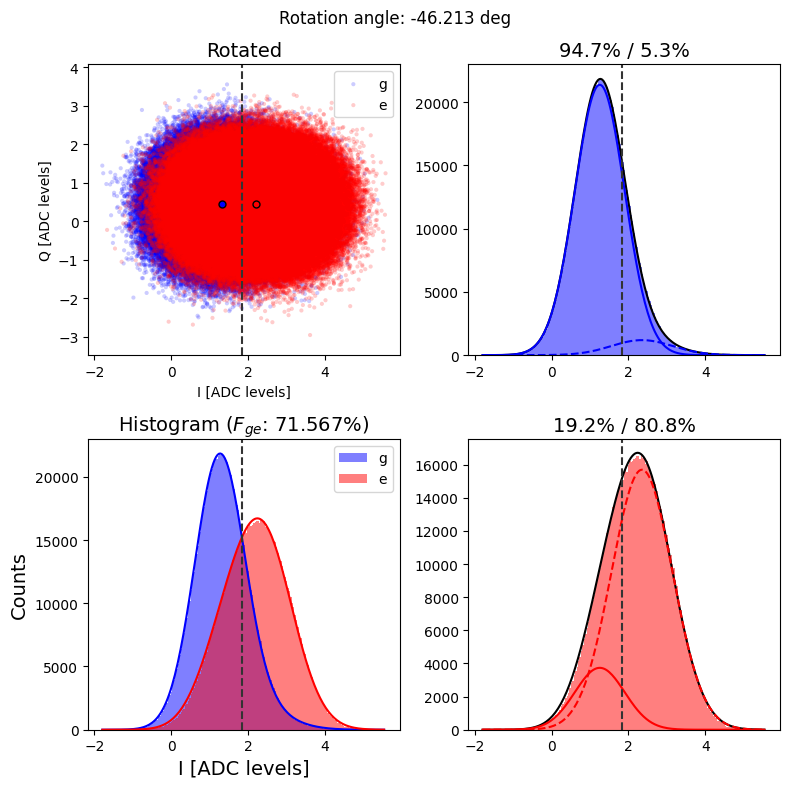

Optimal fidelity after rotation = 71.6%


In [632]:
%matplotlib inline
fid, threshold, angle = zf.singleshot_ge_analysis(signals, plot=True, backend="center")
print(f"Optimal fidelity after rotation = {fid:.1%}")

In [633]:
# filename = f"single_shot_rf_{qub_name}"
filename = f"{qub_name}_singleshot_ge@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "shot", "unit": "point", "values": np.arange(cfg["shots"])},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    y_info={"name": "ge", "unit": "", "values": np.array([0, 1])},
    comment=make_comment(cfg, f"fide {fid:.1%}"),
    tag="SingleShot/ge",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0426\Q4_singleshot_ge@2.500mA_1.hdf5


## Amplitude Rabi Single shot

In [389]:
exp_cfg = {
    "dac": {
        "res_pulse": "readout_dpm",
        "qub_pulse": "pi_amp",
        # "qub_pulse": {
        #     **DefaultCfg.get_pulse("readout_rf"),
        # },
        "reset": "pulse",
        "reset_pulse": "reset_red",
    },
    "adc": {
        "relax_delay": 1.0,  # us
    },
}

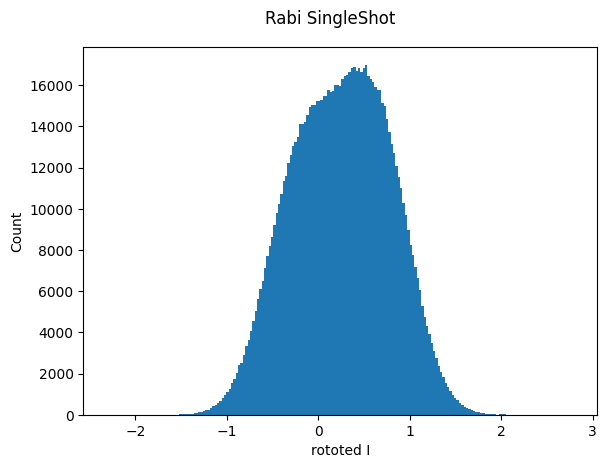

Power:   0%|          | 0/1001 [00:00<?, ?it/s]

In [390]:
exp_cfg["sweep"] = make_sweep(0, 1.0, 1001)
cfg = make_cfg(exp_cfg, shots=1000000)

%matplotlib widget
pdrs, signals = zs.measure_amprabi_singleshot(soc, soccfg, cfg)

Calculating histogram...Fitting dual Gaussian...Plotting...


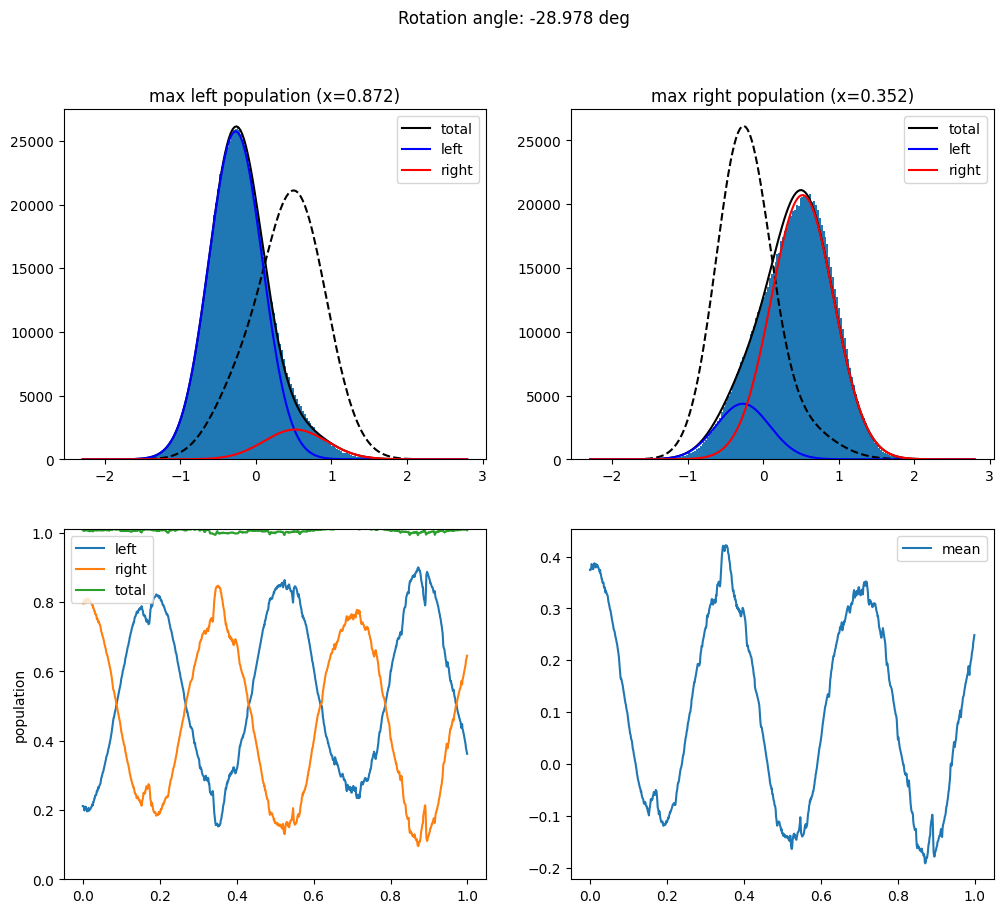

In [391]:
%matplotlib inline
n_g, n_e, _ = zf.single_shot.singleshot_rabi_analysis(pdrs, signals)

In [ ]:
filename = f"{qub_name}_singleshot_rabi@{cur_A * 1e3:.3f}mA"
save_data(
    filepath=os.path.join(database_path, filename),
    x_info={"name": "shot", "unit": "point", "values": np.arange(cfg["shots"])},
    z_info={"name": "Signal", "unit": "a.u.", "values": signals},
    y_info={"name": "Power", "unit": "a.u.", "values": pdrs},
    comment=make_comment(cfg),
    tag="SingleShot/amp_rabi",
    server_ip=data_host,
)

Successfully saved data to  c:\Users\QEL\Desktop\MeasureScriptX\QuantumMeasurementProcedures\Members\axel\Qubit-measure\Database\Q12_2D\Q4\2025\04\Data_0425\Q4_singleshot_rabi@4.000mA_2.hdf5


# Dump Configurations

In [188]:
DefaultCfg.dump("default_cfg.yaml")